<a href="https://colab.research.google.com/github/Prerit-Bhagat/Clustering/blob/main/Clustering_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Iris dataset
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)

# Evaluation function
def evaluate_clustering(X, labels):
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    return silhouette, ch_score, db_score

# Preprocessing strategies
preprocessing_combinations = {
    'Raw': lambda X: X,
    'Normalized': lambda X: StandardScaler().fit_transform(X),
    'Transformed': lambda X: PowerTransformer().fit_transform(X),
    'PCA': lambda X: PCA(n_components=2).fit_transform(X),
    'Norm+Trans': lambda X: PowerTransformer().fit_transform(StandardScaler().fit_transform(X)),
    'Norm+Trans+PCA': lambda X: PCA(n_components=2).fit_transform(PowerTransformer().fit_transform(StandardScaler().fit_transform(X)))
}

cluster_counts = [2, 3, 4, 5]
results = []

best_score = -1
best_config = {}


In [2]:
# Iterate over preprocessing and clustering combinations
for method in preprocessing_combinations:
    X_processed = preprocessing_combinations[method](data)
    for k in cluster_counts:
        # KMeans
        km = KMeans(n_clusters=k, random_state=42)
        km_labels = km.fit_predict(X_processed)
        sil, ch, db = evaluate_clustering(X_processed, km_labels)
        results.append(["KMeans", method, k, sil, ch, db])
        if sil > best_score:
            best_score = sil
            best_config = {"Method": "KMeans", "Preprocessing": method, "Clusters": k, "Silhouette": sil}

        # Hierarchical Clustering
        hc = AgglomerativeClustering(n_clusters=k)
        hc_labels = hc.fit_predict(X_processed)
        sil, ch, db = evaluate_clustering(X_processed, hc_labels)
        results.append(["Hierarchical", method, k, sil, ch, db])
        if sil > best_score:
            best_score = sil
            best_config = {"Method": "Hierarchical", "Preprocessing": method, "Clusters": k, "Silhouette": sil}

    # MeanShift (no fixed k)
    try:
        ms = MeanShift(bandwidth=estimate_bandwidth(X_processed, quantile=0.2))
        ms_labels = ms.fit_predict(X_processed)
        k_ms = len(np.unique(ms_labels))
        sil, ch, db = evaluate_clustering(X_processed, ms_labels)
        results.append(["MeanShift", method, k_ms, sil, ch, db])
        if sil > best_score:
            best_score = sil
            best_config = {"Method": "MeanShift", "Preprocessing": method, "Clusters": k_ms, "Silhouette": sil}
    except:
        pass


In [4]:
# Results DataFrame
results_df = pd.DataFrame(results, columns=["Method", "Preprocessing", "Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
results_df.to_csv("iris_clustering_results.csv", index=False)

# Print full results
print("\n📊 Clustering Evaluation Results:")
print(results_df)

# Print best configuration
print("\n✅ Best Clustering Configuration:")
print(f"Method: {best_config['Method']}")
print(f"Preprocessing: {best_config['Preprocessing']}")
print(f"Number of Clusters: {best_config['Clusters']}")
print(f"Silhouette Score: {best_config['Silhouette']:.4f}")



📊 Clustering Evaluation Results:
          Method   Preprocessing  Clusters  Silhouette  Calinski-Harabasz  \
0         KMeans             Raw         2    0.681046         513.924546   
1   Hierarchical             Raw         2    0.686735         502.821564   
2         KMeans             Raw         3    0.551192         561.593732   
3   Hierarchical             Raw         3    0.554324         558.058041   
4         KMeans             Raw         4    0.497643         529.529095   
5   Hierarchical             Raw         4    0.488967         515.078906   
6         KMeans             Raw         5    0.493080         495.243414   
7   Hierarchical             Raw         5    0.484383         488.484904   
8      MeanShift             Raw         2    0.685788         509.703427   
9         KMeans      Normalized         2    0.581750         251.349339   
10  Hierarchical      Normalized         2    0.577035         240.245665   
11        KMeans      Normalized         3

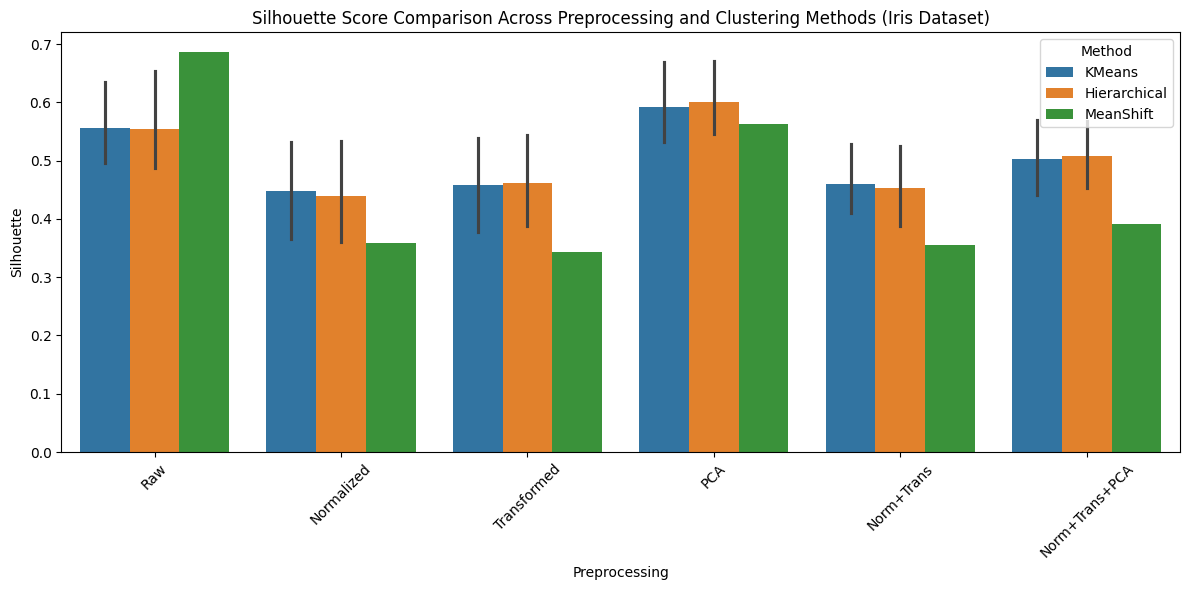

In [5]:
# Plot silhouette score comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Preprocessing", y="Silhouette", hue="Method")
plt.title("Silhouette Score Comparison Across Preprocessing and Clustering Methods (Iris Dataset)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()